# Builds a custom CNN for Lunar Crater Classification (LROCNet).

### 1. Started with classic pattern: Conv2D -> BN -> ReLU -> Pooling 
 ##### Main target -the pipeline running 
 ##### Architect - 3 convoluation blocks, Flaten, 1 Dense layer

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import os
import matplotlib.pyplot as plt

2025-12-09 12:59:26.590080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Data directories
DATA_DIR = "/home/santanu/code/VMontejo/lunar-crater-age-classifier/raw_data/train"


In [5]:
IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.0001
NUM_CLASSES = 3

### 2. Data Loading (Standardization Pipeline)

In [7]:
DATASET_MEAN = 127.5  # extracted from Lornet EDA.ipynb
DATASET_STD  = 60.0  # extracted from Lornet EDA.ipynb

def z_score_standardization(image):
    """
    Applies (Pixel - Mean) / Std to every pixel.
    Input image is 0-255.
    """
    image = tf.cast(image, tf.float32)
    return (image - DATASET_MEAN) / DATASET_STD

In [8]:
# 1. Create the Data Generator with Custom Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=z_score_standardization, # <--- Z-Score happens here
    validation_split=0.2
)

In [ ]:
# 2. Setup Training Generator (RGB Mode)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

Found 2888 images belonging to 3 classes.


In [ ]:
#3. Setup Validation Generator (RGB Mode)
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=False
)

Found 720 images belonging to 3 classes.


In [17]:
print(f" Pipeline Configured: Input (227, 227, 3) | Normalization: Z-Score")

 Pipeline Configured: Input (227, 227, 3) | Normalization: Z-Score


#### 2.1 Calculate class weight

⚠️ ARCHITECT REPORT: Imbalance Corrective Weights
Class 0 (Fresh): 3.36x (High Priority)
Class 1 (None):  0.45x (Low Priority)
Class 2 (Old):   2.01x (Medium Priority)


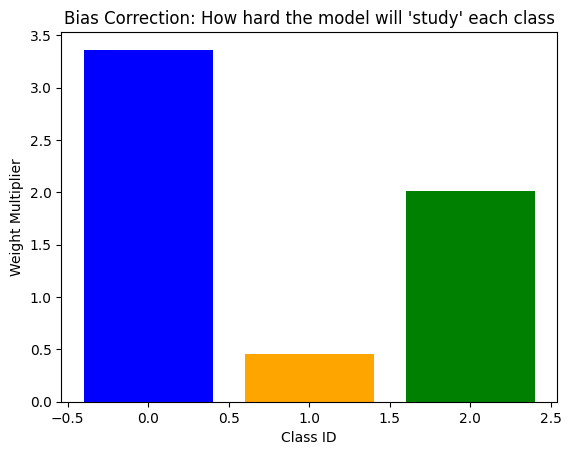

In [25]:
from sklearn.utils import class_weight
import numpy as np

# 1. Get the exact counts from your previous step (replace with your actual variables)
# Based on your graph, I am estimating:
y_train_labels = []
# Simulating your dataset structure for the calculator
# In reality, you would pass your actual label array here: train_generator.classes
counts = {
    0: 358,   # ejecta (fresh)
    1: 2656,  # none
    2: 598    # oldcrater
}

# Expand into a list for the calculation function
y_train_simulated = []
for label, count in counts.items():
    y_train_simulated.extend([label] * count)

# 2. Calculate the weights automatically
# Formula: Total / (Num_Classes * Class_Count)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_simulated),
    y=y_train_simulated
)

# 3. Create the dictionary for Keras
class_weights_dict = dict(enumerate(class_weights_vals))

print("⚠️ ARCHITECT REPORT: Imbalance Corrective Weights")
print(f"Class 0 (Fresh): {class_weights_dict[0]:.2f}x (High Priority)")
print(f"Class 1 (None):  {class_weights_dict[1]:.2f}x (Low Priority)")
print(f"Class 2 (Old):   {class_weights_dict[2]:.2f}x (Medium Priority)")

# VISUALIZATION OF BIAS CORRECTION
import matplotlib.pyplot as plt
plt.bar(counts.keys(), list(class_weights_dict.values()), color=['blue', 'orange', 'green'])
plt.title("Bias Correction: How hard the model will 'study' each class")
plt.xlabel("Class ID")
plt.ylabel("Weight Multiplier")
plt.show()

### 3. Custom Architect Model


In [26]:
def build_lroc_model(input_shape, num_classes):
    model = models.Sequential(name="LROC_Custom_CNN_RGB")

    #---input Block----
    model.add(layers.InputLayer(shape=input_shape))

    #---Block1: Edge&Lines---
    model.add(layers.Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block2: Simple Shape---
    model.add(layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block3: Complex texture---
    model.add(layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block 4: Deeper Features(Rays/Ejecta)---
    model.add(layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Classification Block---
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [27]:
# Build with RGB shape
model = build_lroc_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

Model: "LROC_Custom_CNN_RGB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 227, 227, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 227, 227, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 227, 227, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 113, 113, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 113, 113, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,899 (1.74 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

### 4. Compile and save model

In [28]:
# 1. Compile
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# 2. Define Callbacks
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Save the best model automatically in the native Keras format
    ModelCheckpoint('best_lroc_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),

    # Slow down learning rate if the model gets stuck
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

print("✅ Model compiled. Callbacks configured to save as .keras")


✅ Model compiled. Callbacks configured to save as .keras


### 5.Training (Model Fit)

In [29]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)
print ("✅ Model Training Complete!")


Epoch 1/25
10/90 ━━━━━━━━━━━━━━━━━━━━ 11:00 8s/step - accuracy: 0.1508 - loss: 1.5735 - precision: 0.1558 - recall: 0.1073

KeyboardInterrupt: 

### 6. Performance Visualization

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)